(5,0,0.5), (1,0,0.5), (3,0,0.5), 
Blown up is: 
(5,0,0.5), (0,0,0.5), (-1,0,100), (2,0,0.5), 
Transferred is: 
(3,0,0.5), (0,0,0.5), (1,0,100), (2,0,0.5), 
This arm is the space L(7,2)
(4,0,0.78), (1,0,0.45), (6,0,0.345), (7,0,0.45), (8,0,0.89), 
(7,0,0.45) now has index 3
(8,0,0.89) now has index 4
Blown up is: 
(4,0,0.78), (0,0,0.45), (-1,0,100), (5,0,0.345), (7,0,0.45), (8,0,0.89), 
Transferred is: 
(2,0,0.78), (0,0,0.45), (1,0,100), (5,0,0.345), (7,0,0.45), (8,0,0.89), 
This arm is the space L(746,267)
(3,0,0.56), (1,0,0.78), (5,0,0.543), (7,0,0.67), (4,0,0.46), (4,0,0.54), (6,0,0.45), (78,0,0.67), (8,0,0.565), (4,0,0.45), 
(7,0,0.67) now has index 3
(4,0,0.46) now has index 4
(4,0,0.54) now has index 5
(6,0,0.45) now has index 6
(78,0,0.67) now has index 7
(8,0,0.565) now has index 8
(4,0,0.45) now has index 9
Blown up is: 
(3,0,0.56), (0,0,0.78), (-1,0,100), (4,0,0.543), (7,0,0.67), (4,0,0.46), (4,0,0.54), (6,0,0.45), (78,0,0.67), (8,0,0.565), (4,0,0.45), 
Transferred is: 
(1,0,0

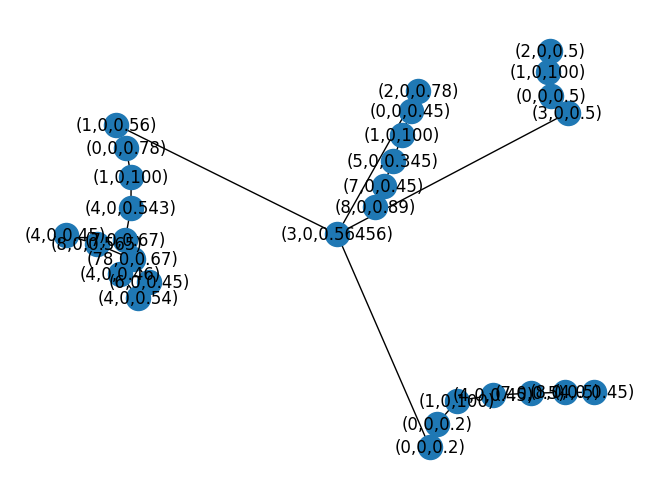

In [11]:
import networkx as nx
import numpy as np
from fractions import Fraction
from decimal import Decimal

class PlumbingNode:
    def __init__(self, euler_number: int, g: int, a: float):
        """Instantiates a new PlumbingNode with specified attributes
        
            Args:
                euler_number (int): The integer Euler number of the associated bundle
                g (int): The genus of the base surface of the associated bundle
                a (float): The symplectic area of the base surface
        """
        self.euler_number = euler_number
        self.genus = g
        self.area = a
    
    def __str__(self):
        return "({0},{1},{2})".format(self.euler_number, self.genus, self.area)

class PlumbingGraph(nx.Graph):
    def __init__(self):
        """Instantiates a new PlumbingGraph which is a subclass of nx.Graph
        
        """
        self.chains = []
        super(PlumbingGraph,self).__init__()
        
    def add_node(self, node_for_adding: PlumbingNode, **attr):
        """Add a node to the graph
            
            Args:
                node_for_adding (PlumbingNode): The node to be added
                **attr: Optional dict within a dict of attributes for the nodes.
        """
        assert(type(node_for_adding) == PlumbingNode)
        
        nx.Graph(self).add_node(node_for_adding, **attr)

        
    def total_area(self):
        total = 0
        for n in nodes:
            total += n.area
            
    def total_genus(self):
        total_genus = 0
        for n in nodes:
            total_genus += n.genus
    
    def attach_chain_to(self, node: PlumbingNode, chain):
        """Attaches a chain to a specified node
        
            Args:
               node (PlumbingNode): The node that we are attaching to
               chain (Chain): A plumbing chain to attach
        """
        
        # Add all the edges and nodes
        self.add_nodes_from(chain.nodes)
        self.add_edges_from(chain.edges)
        
        # Connect the head of the chain to node
        self.add_edge(node,chain.head)
        
        # Add the new chain to the chain bank
        self.chains.append(chain)
        
    def attach_chain_between(self, node1: PlumbingNode, node2: PlumbingNode, chain):
        """Attaches a chain between two specified nodes
        
            Args:
                node1 (PlumbingNode): The node which we will attach the head of the chain to
                node2 (PlumbingNode): The node which we will attach the tail of the chain to
        """
        
        # Add all the edges and nodes
        self.add_nodes_from(chain.nodes)
        self.add_edges_from(chain.edges)
        
        # Connect the head and tail of the chain to the respective nodes
        self.add_edge(node1, chain.head)
        self.add_edge(node2, chain.tail)
        
        # Add the new chain to the chain bank
        self.chains.apppend(chain)
        
            

        
            
class Chain(PlumbingGraph):
    def __init__(self, components: [int], area: [float]):
        """ Instantiates a new Chain from input data
        
            Args:
                components ([int]): A list of integer components for the chain
                area ([float]): A list of symplectic area information for each node
        """
        
        # Check if the input data is valid
        if len(area) != len(components):
            raise Exception("Area vector does not match the size of the arm.")
        
        super(Chain,self).__init__()
        
        self.order_function = {}
        self.index_lookup = {}
        self.length = len(components)
        
        # Attach nodes in a linear fashion keeping track of order and indices
        for i,k in enumerate(components):
            
            # Create and add a new node to the chain
            current_node = PlumbingNode(k, 0, area[i])
            self.add_node(current_node)
            
            # The first node is the head
            if i == 0:
                self.head = current_node
                
            # The last node is the tail
            elif i == self.length - 1:
                self.tail = current_node
                self.add_edge(previous_node, current_node)
            
            # Otherwise, we just attach the new node
            else:
                self.add_edge(previous_node, current_node)
            
            # Set the index and ordering information
            self.order_function[i] = current_node
            self.index_lookup[current_node] = i
            
            # Save the previous node for the next attachment
            previous_node = current_node
        
        # Compute the associated continued fraction for the chain
        self.associated_rational = compute_continued_fraction(components)
    
    def blow_up(self, i: int, area: float):
        """Perform a combinatorial -1 blow-up on the edge between node i and node i+1
        
            Args:
                node1 (PlumbingNode): One node connected to the edge
                node2 (PlumbingNode): The other node connected to the edge
        """
        
        # Check if i is in the correct range
        if i >= self.length - 1 or i < 0:
            raise Exception("Index out of range!")
        
        
        # Add the new node
        new_node = PlumbingNode(-1,0,area)
        self.add_node(new_node)
        self.length += 1
        
        # Remove the old edge and connect the endpoints to the new node
        self.remove_edge(self.order_function[i], self.order_function[i+1])
        self.add_edge(self.order_function[i], new_node)
        self.add_edge(new_node, self.order_function[i+1])        

        # The rest of the function updates self.order_function and self.index_lookup
        previous_node = None
        current_node = None
        
        # The nodes before node i are left alone and the nodes after are updated
        for j in range(i+1, self.length):
            
            # The first node after node i is the new node
            if j == i+1:
                previous_node = self.order_function[j]
                self.order_function[j] = new_node
                self.index_lookup[new_node] = j
            
            # The last node on the chain extends the whole chain by one
            elif j == self.length - 1:
                self.order_function[j] = previous_node
                self.index_lookup[previous_node] = j
            
            # The nodes in between are bumped up a space
            else:
                current_node = self.order_function[j]
                
                self.order_function[j] = previous_node
                self.index_lookup[previous_node] += 1
                
                previous_node = current_node
                print("{} now has index {}".format(previous_node, self.index_lookup[previous_node]))
                
        # Update Euler numbers
        self.order_function[i].euler_number -= 1
        self.order_function[i+2].euler_number -= 1
        
        
    def transfer_right(self, i: int, k: int):
        
        assert(i < self.length and i >= 0)
    
        # We can only transfer at a 0-framed node
        assert(self.order_function[i].euler_number == 0)
        
        if i == 0:
            nieghbor_set = set(self.neighbors(self.head)) - {self.order_function[i+1]} 
            for n in neighbor_set:
                n.euler_number -= k
                
            self.order_function[i+1].euler_number += k
        elif i == self.length - 1:
            if len(self.neighbors(self.tail)) == 1:
                self.order_function[self.length - 2].euler_number -= k
            else:
                self.order_function[i-1] -= k
                neighbor_set = set(self.neighbors(self.tail)) - {self.order_function[i-1]}
                for n in neighbor_set:
                    n.euler_number += k
        else:
            self.order_function[i-1].euler_number -= k
            self.order_function[i+1].euler_number += k
     
    def transfer_left(self, i: int, k: int):
        self.transfer_right(i, -k)
    
    def slide_far_left(self, i: int):
        
        assert(i < self.length and i >= 0)
    
        # We can only slide a 0-0 configuration
        assert(self.order_function[i].euler_number == 0 and self.order_function[i+1].euler_number == 0)
        
        
        
    def __iter__(self):
        self.iteration = 0
        
    def __next__(self):
        if self.iteration < self.length:
            self.iteration += 1
            return order_function[self.iteration - 1]
        else:
            raise StopIteration
            
    def __str__(self):
        out = ""
        for i in range(self.length):
            out += str(self.order_function[i]) + ', '
            
        return out
            

def compute_continued_fraction(components: [int]) -> Fraction:
    """Compute the continued fraction expansion associated to an integer list of components
    
        Args:
            components ([int]): a list of the integer components of the continued fraction
            
        Return:
            A Fraction which is the reduced version of the associated rational number
    """
    if len(components) == 1:
        return Fraction(components[0],1)
    
    return Fraction(components[0],1) - 1/compute_continued_fraction(components[1:])




G = PlumbingGraph()

root_node = PlumbingNode(3,0,.56456)
G.add_node(root_node)

arms = [
    [5,1,3],
    [4,1,6,7,8],
    [3,1,5,7,4,4,6,78,8,4],
    [2,1,5,7,8,4]
]

areas = [
    [0.5,0.5,0.5],
    [.78,.45,.345,.45,.89],
    [.56, .78, .543, .67, .46, .54, .45, .67, .565, .45],
    [.2, .2, .45, .5, .5, .45]
]

for i,arm in enumerate(arms):
    c = Chain(arm, areas[i])
    print(c)
    
    c.blow_up(1,100)
    print("Blown up is: ")
    print(c)
    
    c.transfer_right(1,2)
    print("Transferred is: ")
    print(c)
    
    r = c.associated_rational
    print("This arm is the space L({0},{1})".format(r.numerator,r.denominator))

    G.attach_chain_to(root_node, c)

                 
# Plot the result
edge_nodes = set(G) - {root_node}
pos = nx.spring_layout(G.subgraph(edge_nodes))
pos[root_node] = np.array([0, 0])  
nx.draw(G, pos, with_labels=True)




